# Определение возраста покупателей / Determining the age of customers

## Описание проекта / Project description

В этом проекте мы будем строить модель машинного обучения для распознавания возраста покупателя по его фотографии. Эта модель будет использоваться супермаркетом для:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Для этого будем использовать размеченные данные, где каждой фотографии человека соответствует его возраст.
___
Our plan is to build a ML model for age prediction by face photograph in the supermarket. It will allow to:
- analyse purchases and make recommendations,
- control the age of customers selling alcohol and cigarettes.

To do this, we will use labeled data, where each photo of a person corresponds to his age.

In [ ]:
# импортируем все библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Исследовательский анализ данных / Exploatory data analysis

In [3]:
# файл с лэйблами / file with labels
labels_df = pd.read_csv('/datasets/faces/labels.csv')

# размерность таблицы / table shape
print('Размерность таблицы с лэйблами:', labels_df.shape)

labels_df.head()

Размерность таблицы с лэйблами: (7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# проверим пропуски / missing values check
labels_df.isna().sum()

file_name    0
real_age     0
dtype: int64

In [5]:
labels_df['file_name'].str.contains('.jpg').sum()

7591

In [6]:
# настроим генератор данных картинок / set the image egenerator
gen = ImageDataGenerator(rescale=1/255)

# считаем картинки используя датафрэйм с лэйблами / read pictures using df with labels
images = gen.flow_from_dataframe(dataframe=labels_df,
                                directory='/datasets/faces/final_files',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(150,150),
                                batch_size=16,
                                class_mode='raw',
                                seed=123)

Found 7591 validated image filenames.


In [7]:
# создадим массив с пикселями картинок чтобы построить графики с ними
# create an array with pixels of images to plot them
images_array = next(images)

Напечатаем 10 изображений на экран.
___
Plot 10 images.

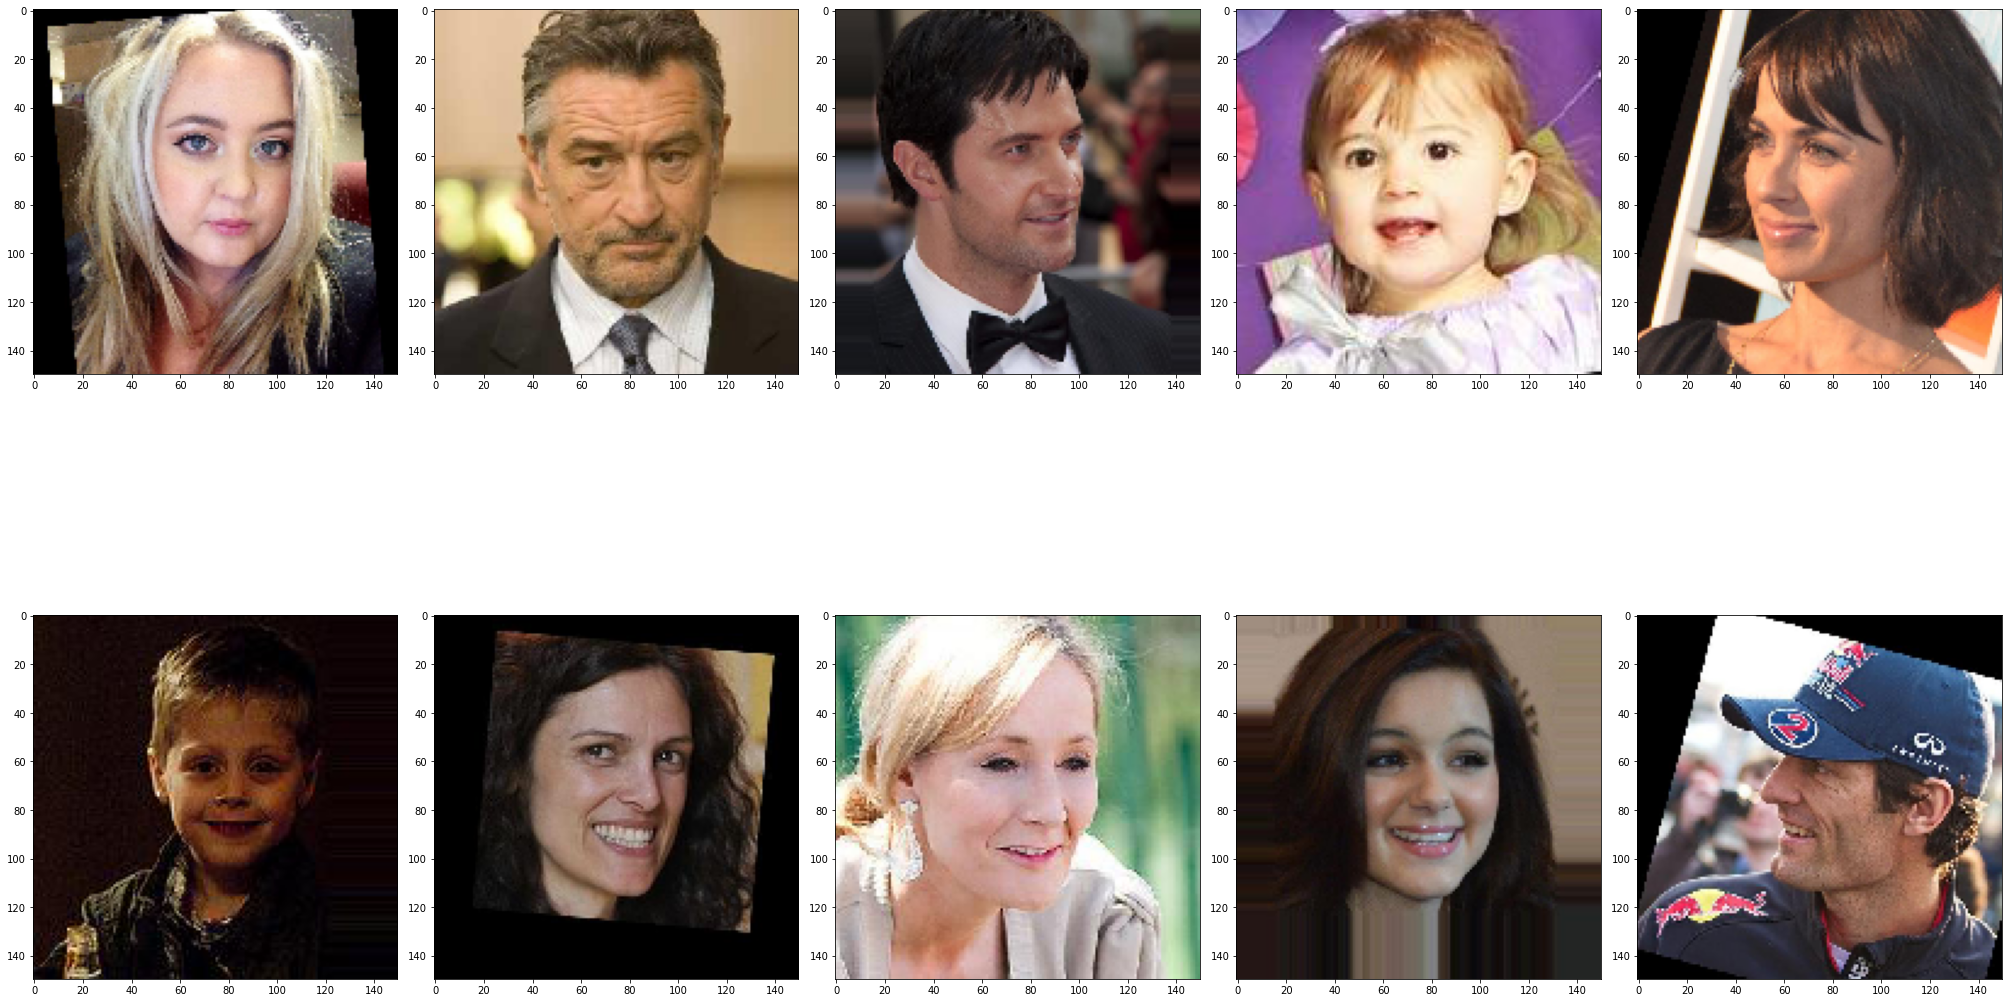

In [8]:
f, ax = plt.subplots(2,5, figsize=(28,28))
for i, ax in enumerate(ax.flatten()):
    image = images_array[0][i]
    ax.imshow(image)
    plt.tight_layout() 
    
plt.show()

Посмотрим на распределение возраста в данных.
___
Distribution of age.

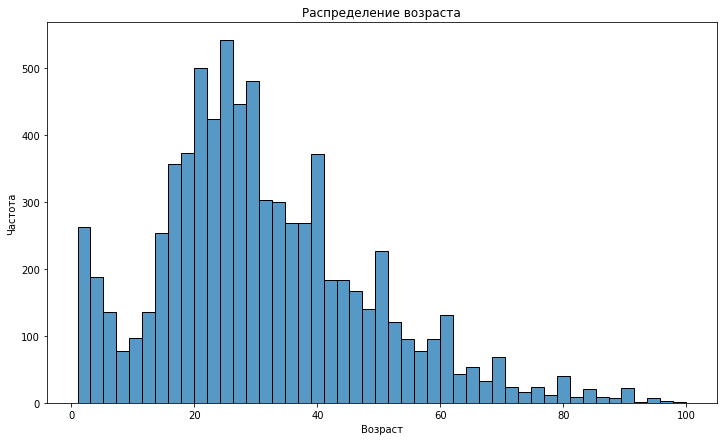

In [9]:
plt.figure(figsize=(12,7))
sb.histplot(labels_df['real_age'])
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение возраста');

### Вывод / Summary

В нашем распоряжении 7591 фотография людей различного возраста. Возраст имеет нормальное распределение со смещением вправо.

Наши изображения с лицами людей расположены в одной директории, они не разделены по папкам с отдельными возрастами. Поэтому, использовали загрузчик данных **flow_from_dataframe**. Фотографии цветные, а значит изображение строится из трех цветовых каналов: зеленого, красного, и синего.

Перед нами задача регрессии, предсказать возраст по фотографии человека.
____
We have 7591 photographs of people of various ages at our disposal. Age has a normal distribution with a shift to the right.

Our images with people's faces are located in the same directory, they are not divided into folders with separate ages. Therefore, we used the data loader **flow_from_dataframe**. Photos are color, which means that the image is built from three color channels: green, red, and blue.

Before us is the task of regression, to predict the age from a photograph of a person.

## Обучение модели / Model training

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.
____
The code in this section is run in a separate GPU trainer, so it is formatted not as a cell with code, but as code in a text cell.

```python

def load_train(path):
    
    datagen_train = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)

    labels_df = pd.read_csv(path+'labels.csv')

    train_data = datagen_train.flow_from_dataframe(dataframe=labels_df,
                                directory=path+'/final_files',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(150,150),
                                batch_size=32,
                                class_mode='raw',
                                subset='training',
                                seed=123)

    return train_data

def load_test(path):

    datagen_test = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)

    labels_df = pd.read_csv(path+'labels.csv')

    test_data = datagen_test.flow_from_dataframe(dataframe=labels_df,
                                directory=path+'/final_files',
                                x_col='file_name',
                                y_col='real_age',
                                target_size=(150,150),
                                batch_size=32,
                                class_mode='raw',
                                subset='validation',
                                seed=123)

    return test_data

def create_model(input_shape):

    optimizer = Adam(learning_rate=0.0005)

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(loss=[MeanSquaredError()],
                  optimizer=optimizer,
                  metrics=[MeanAbsoluteError()])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

Выод тренировки из GPU-тренажёра.
____
Output of training from GPU trainer.

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 47s - loss: 209.5509 - mean_absolute_error: 10.7561 - val_loss: 489.5511 - val_mean_absolute_error: 16.8877

Epoch 2/10
178/178 - 37s - loss: 100.6625 - mean_absolute_error: 7.6204 - val_loss: 743.8719 - val_mean_absolute_error: 22.1617

Epoch 3/10
178/178 - 37s - loss: 60.3996 - mean_absolute_error: 5.9193 - val_loss: 395.0247 - val_mean_absolute_error: 14.7066

Epoch 4/10
178/178 - 37s - loss: 39.7401 - mean_absolute_error: 4.8269 - val_loss: 180.8711 - val_mean_absolute_error: 10.4840

Epoch 5/10
178/178 - 38s - loss: 25.4057 - mean_absolute_error: 3.8907 - val_loss: 102.4740 - val_mean_absolute_error: 7.4757

Epoch 6/10
178/178 - 38s - loss: 16.9121 - mean_absolute_error: 3.1716 - val_loss: 82.0877 - val_mean_absolute_error: 6.8161

Epoch 7/10
178/178 - 38s - loss: 13.4342 - mean_absolute_error: 2.7998 - val_loss: 76.3339 - val_mean_absolute_error: 6.5996

Epoch 8/10
178/178 - 38s - loss: 10.8204 - mean_absolute_error: 2.5044 - val_loss: 79.5126 - val_mean_absolute_error: 6.7553

Epoch 9/10
178/178 - 37s - loss: 9.2042 - mean_absolute_error: 2.3154 - val_loss: 85.9749 - val_mean_absolute_error: 7.1617

Epoch 10/10
178/178 - 35s - loss: 8.2434 - mean_absolute_error: 2.1962 - val_loss: 76.1027 - val_mean_absolute_error: 6.6220
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 76.1027 - mean_absolute_error: 6.6220
Test MAE: 6.6220

```

## Анализ обученной модели / Evaluation of trained model

Для выполнения поставленной задачи была применена сверточная нейронная сеть ResNet50. Ее архитектура уже есть в библиотеке Keras, мы только изменили два последних слоя, добавив к нему GlobalAveragePooling и полносвязный слой с одним нейроном с функцией активации ReLu. Количество нейронов в выходном слое, а также функция активации обусловлены поставленной задачей. Перед нами стояла задача регрессии - предсказание численной (дискретной) величины по определенному набору признаков.

После обучения модели метрика MAE на тестовых данных составила 6,62. Т.е наша модель предсказывает возраст по фотографии, ошибаясь в среднем почти на 7 лет. При применении нашей сети для рекомендации товаров это, скорее всего, не составит проблемы. А вот при контроле кассиров при продаже товаров из возрастной категории 18+ могут возникнуть спорные ситуации. Например, 21-летний парень покупает алкоголь, но сисетма помечает его как покупателя с возрастом 14 лет. К кассиру могут быть предъявлены притензии (штраф, увольнение). Когда наша модель принимает судьбоносные решения, мы должны удостовериться в ее качестве. Конечно, можно проверять достоверность модели по камерам, но тогда вопрос для чего вообще нужна модель? К тому же, если магазин большой, проверять косяки всех кассиров по камерам дело времязатратное.

Модель необходимо дорабатывать, добиваясь меньшего значения метрики МАЕ. Также, в ходе обучения было замечено, что модель переобучается: MAE на тренировочных данных всегда значительно меньше, чем MAE на тестовых данных.
_____
To accomplish the task, a ResNet50 convolutional neural network was used. Its architecture is already in the Keras library, we only changed the last two layers by adding GlobalAveragePooling to it and a fully connected layer with one neuron with the ReLu activation function. The number of neurons in the output layer, as well as the activation function, are determined by the task. We were faced with the task of regression - the prediction of a numerical (discrete) value for a certain set of features.

After training the model, the MAE metric on the test data was 6.62. That is, our model predicts age from a photograph, being wrong on average by almost 7 years. When using our network to recommend products, this is likely not to be a problem. But when controlling cashiers when selling goods from the age category 18+, disputable situations may arise. For example, a 21-year-old guy buys alcohol, but the system marks him as a buyer at the age of 14. Claims may be brought against the cashier (fine, dismissal). When our model makes life-changing decisions, we must ensure its quality. Of course, you can check the reliability of the model by cameras, but then the question is why do we need a model at all? In addition, if the store is large, it is time-consuming to check the jambs of all cashiers on cameras.

The model needs to be refined, achieving a lower value of the MAE metric. Also, during the training, it was noticed that the model is overfitting: the MAE on the training data is always significantly less than the MAE on the test data.